In [2]:
import sympy as sp
import numpy as np
from Modules.sympy.classes import *
from Modules.sympy.utils import *

# Truncated System for Numerical Calculations

In [64]:
dim_spin = 2
dim_reso = 5
Spin = RDBasis("\\sigma", 'spin', dim = dim_spin)
sx = Spin.project(sp.Matrix([[0, 1], [1, 0]]))
sz = Spin.project(sp.Matrix([[1, 0], [0, -1]]))

a = RDBoson("a", subspace = "boson", dim_projection = dim_reso)
ad = RDBoson("{a^\\dagger}", subspace = "boson", is_annihilation=False, dim_projection = dim_reso)

subspaces = [[Spin.subspace, dim_spin], [a.subspace, dim_reso]]

hbar = RDsymbol("hbar", order = 0)
omega = RDsymbol("omega", order = 0)
Omega_z = RDsymbol("\\Omega_{z}", order = 0)
g = RDsymbol("g", order = 1)

H0 = hbar * omega * ad * a + hbar * Omega_z * sp.Rational(1,2) * sz
H_num = H0 - hbar * g * (a + ad) * sx

get_matrix(H_num, subspaces)

Matrix([
[\Omega_{z}*hbar/2,                              0,                                0,                                0,                                0,                  0,                         -g*hbar,                                 0,                                 0,                                 0],
[                0, \Omega_{z}*hbar/2 + hbar*omega,                                0,                                0,                                0,            -g*hbar,                               0,                   -sqrt(2)*g*hbar,                                 0,                                 0],
[                0,                              0, \Omega_{z}*hbar/2 + 2*hbar*omega,                                0,                                0,                  0,                 -sqrt(2)*g*hbar,                                 0,                   -sqrt(3)*g*hbar,                                 0],
[                0,                              0, 

In [132]:
def project_energy(H_mat, spin_state, boson_state):
    ket_state = zeros(dim_spin, 1)
    ket_state[spin_state] = 1
    boson_states = zeros(dim_reso, 1)
    boson_states[boson_state] = 1
    
    state = sp.kronecker_product(ket_state, boson_states)
    return sp.transpose(state) * H_mat * state

In [133]:
subs_numerical_values ={
    hbar: 1,
    omega: 10,
    Omega_z: 7,
    g: 0.1
}

In [134]:
H_num_mat = get_matrix(H_num, subspaces).subs(subs_numerical_values)
# Find the eigenvalues and eigenvectors of the Hamiltonian
_, D = H_num_mat.diagonalize()
num_energies = np.sort(np.array(list(D.diagonal()), np.float128))
num_energies

array([-3.50058825,  3.49666925,  6.50215422, 13.49393192, 16.5048915 ,
       23.49119973, 26.50762397, 33.48848366, 36.51328117, 43.50235282],
      dtype=float128)

# Untruncated Rabi Model

In [27]:
from Modules.sympy.untruncated.solver import *

In [71]:
dim_spin = 2
dim_reso = 5

Spin = RDBasis("\\sigma", 'spin', dim = dim_spin)
sx = Spin.project(sp.Matrix([[0, 1], [1, 0]]))
sz = Spin.project(sp.Matrix([[1, 0], [0, -1]]))

a = RDBoson("a", subspace = "boson", dim_projection = dim_reso)
ad = RDBoson("{a^\\dagger}", subspace = "boson", is_annihilation=False, dim_projection = dim_reso)
commutation_relations = {
    a*ad: ad * a + 1,
}

hbar = RDsymbol("hbar", order = 0)
omega = RDsymbol("omega", order = 0)
Omega_z = RDsymbol("\\Omega_{z}", order = 0)
g = RDsymbol("g", order = 1)

H = hbar * omega * ad * a + hbar * Omega_z * sp.Rational(1,2) * sz - hbar * g * (a + ad) * sx
H

\Omega_{z}*hbar*\sigma_{3}/2 - g*hbar*(a + {a^\dagger})*\sigma_{1} + hbar*omega*{a^\dagger}*a

In [138]:
energies_block = []
energies_full = []
max_order = 4

for order in range(1, max_order+1):
    sol = solver(H, Spin, order=order, full_diagonal=False, commutation_relations=commutation_relations)
    energies_sol = get_matrix(sol[0], subspaces).subs(subs_numerical_values)
    energies_block.append(np.sort(np.array(list(energies_sol.diagonal()), np.float128)))

    sol = solver(H, Spin, order=order, full_diagonal=True, commutation_relations=commutation_relations)
    energies_sol = get_matrix(sol[0], subspaces).subs(subs_numerical_values)
    energies_full.append(np.sort(np.array(list(energies_sol.diagonal()), np.float128)))


 40%|████      | 12/30 [00:02<00:03,  4.80it/s]/mnt/c/Users/reasc/OneDrive - Universität Augsburg/PhD_Brain/Python Notebooks/Packages/PySW/Modules/sympy/untruncated/solver.py:397: UserWarning: 
Inconsistency in equations to solve. The equations used to solve for S are not linearly independent.
Full diagonalization up to the selected order for the given problem is not yet supported. We
recommend to either lower perturbation order, or otherwise use the truncated solver.
  warnings.warn('\n' + warnig_message)
100%|██████████| 30/30 [00:25<00:00,  1.20it/s]


In [159]:
import matplotlib.pyplot as plt

# Latex rendering for the plots

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=14)


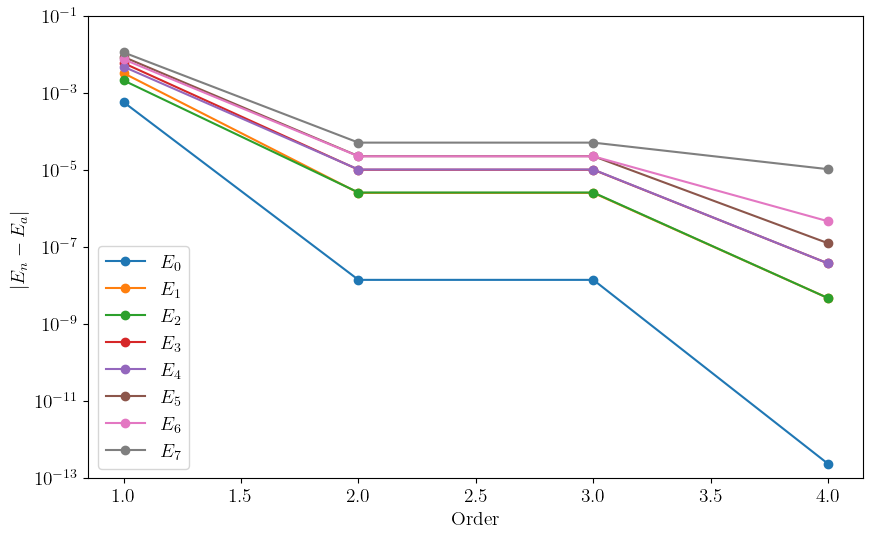

In [168]:

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

energies_order = np.zeros((len(energies_full[0]), max_order), np.float128)

for order, order_energies in enumerate(energies_full):
    result = np.abs(num_energies - order_energies)
    energies_order[:, order] = result

for i, energies in enumerate(energies_order[:-2]):
    ax.plot(np.arange(1, max_order+1), energies, 'o-', label = f"$E_{i}$")

ax.set_yscale("log")
ax.set_ylim(10**-13, 10**-1)
ax.set_xlabel("Order")
ax.set_ylabel(r"$|E_n - E_a|$")
ax.legend()


fig.savefig("Images/Rabi_Full.svg", bbox_inches='tight')

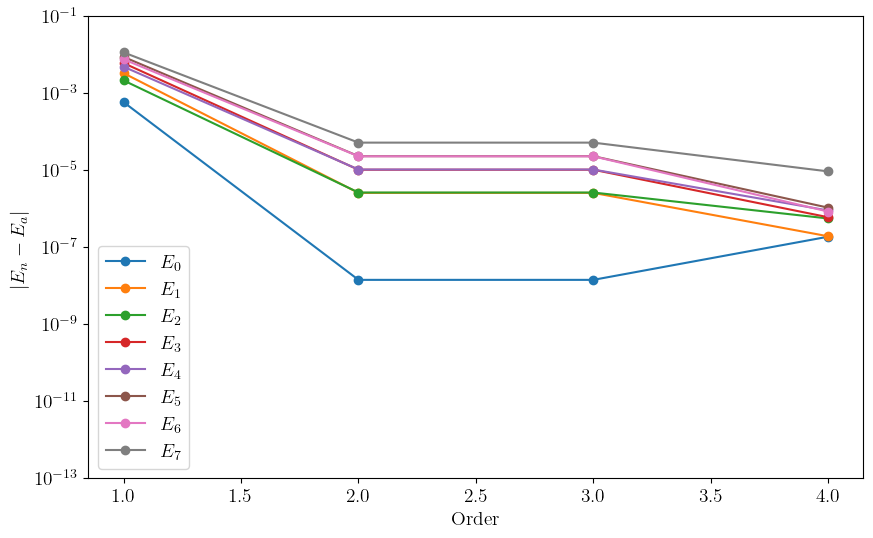

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

energies_order = np.zeros((len(energies_full[0]), max_order), np.float128)

for order, order_energies in enumerate(energies_block):
    result = np.abs(num_energies - order_energies)
    energies_order[:, order] = result

for i, energies in enumerate(energies_order[:-2]):
    ax.plot(np.arange(1, max_order+1), energies, 'o-', label = f"$E_{i}$")

ax.set_yscale("log")

# Scale y-log : 10-12 to 10-1
ax.set_ylim(10**-13, 10**-1)

ax.set_xlabel("Order")
ax.set_ylabel(r"$|E_n - E_a|$")
ax.legend()

fig.savefig("Images/Rabi_Block.svg", bbox_inches='tight')